In [10]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
#import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
#from pmdarima.arima import CHTest, nsdiffs
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

### Import data

In [8]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [11]:
os.path.dirname(os.getcwd())
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path = path_cwd / 'data'

In [12]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_transaction = pd.read_csv(os.path.join(path, 'transactions.csv'))
df_holidays = pd.read_csv(os.path.join(path, 'holidays_events.csv'))
df_oil = pd.read_csv(os.path.join(path, 'oil.csv'))
df_stores = pd.read_csv(os.path.join(path, 'stores.csv'))
df_test = pd.read_csv(os.path.join(path, 'test.csv'))

In [13]:
dtypes = {'id': 'int64', 'store_nbr':'int8', 'onpromotion': str}

# Data Exploration

In [14]:
def get_info_df(df: pd.DataFrame):
    print('============ Shape ============')
    print(df.shape)
    print('============ Data Types ============')
    print(df.info())
    print('============ Missing Values ============')
    print(df.isnull().sum())
    print('============ Duplicated Values ============')
    print(df.duplicated().sum())

In [15]:
get_info_df(df_train)

============ Shape ============
(3000888, 6)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
============ Missing Values ============
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
============ Duplicated Values ============
0


In [16]:
# Helpful to see the unique values in the categorical columns of the DFs
def check_unique_values(df: pd.DataFrame):
    """
    Check the number of unique values in the categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print("Checking unique values in categorical columns:")

    # Iterate through each column
    for col in df.columns:
        # Check if the column is categorical (object type) and not the 'customerID' column
        if ((df[col].dtype == 'object') or (df[col].dtype == 'bool')) and (col != 'id'):
            # Print the column name and its unique values
            print(col, '---->', df[col].unique())

In [17]:
check_unique_values(df_stores)

Checking unique values in categorical columns:
city ----> ['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state ----> ['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type ----> ['D' 'B' 'C' 'E' 'A']


# Data Cleaning

In [18]:
# Just renaming the price column of the oil df

new_oil = df_oil.copy()

new_oil.rename(columns={'dcoilwtico': 'price'}, inplace=True)

In [19]:
new_oil.head(3)

,date,price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


# Data Merging

In [20]:
# Here we write a function that checks the matching columns across all datasets

# Need a class to assign names to the datasets
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name
        
# Function to output the matching pairs
def matching_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]
                
                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [21]:
# name the datasets
datasets = [
    (df_oil, 'Oil'),
    (df_holidays, 'Holidays'),
    (df_stores, 'Stores'),
    (df_transaction, 'Transactions'),
    (df_train, 'Train'),
    (df_test, 'Test')
]

In [22]:
# Use our function to check pairs
matching_pairs(datasets)

Matching columns between Oil and Holidays: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays and Stores: ['type']
Matching columns between Holidays and Transactions: ['date']
Matching columns between Holidays and Train: ['date']
Matching columns between Holidays and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'family', 'onpromotion']


In [23]:
# make a function that compares two dates and checks the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [24]:
# Compare transaction and train
compare_result_train=date_comparison(df_transaction['date'], df_train['date'])

pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [25]:
# Compare transaction and test
compare_result_test=date_comparison(df_transaction['date'], df_test['date'])

pd.DataFrame(compare_result_test)

,Common,Uncommon,Date Range 1,Date Range 2
0,0,1698,2013-01-01,2017-08-16
1,0,1698,2017-08-15,2017-08-31


In [26]:
df_stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


In [27]:
df_train.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [28]:
# Merge oil and train
new_train = df_train.copy()
new_train = pd.merge(df_train, new_oil, on=['date'])

In [29]:
new_train.tail(3)

,id,date,store_nbr,family,sales,onpromotion,price
2143743,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
2143744,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57
2143745,3000887,2017-08-15,9,SEAFOOD,16.000,0,47.57


In [30]:
# Merge holidays, stores, and transactions to new_train
new_train = pd.merge(new_train, df_holidays, on=["date"])
new_train = pd.merge(new_train, df_stores, on=["store_nbr"])
new_train = pd.merge(new_train, df_transaction, on=["date", 'store_nbr'])

In [31]:
# Doing some renaming
new_train.rename(columns={'type_x':'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [32]:
# See if we have any missing values
new_train.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
price           22044
holiday_type        0
locale              0
locale_name         0
description         0
transferred         0
city                0
state               0
store_type          0
cluster             0
transactions        0
dtype: int64

In [33]:
new_train.shape

(322047, 17)

In [34]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            322047 non-null  int64  
 1   date          322047 non-null  object 
 2   store_nbr     322047 non-null  int64  
 3   family        322047 non-null  object 
 4   sales         322047 non-null  float64
 5   onpromotion   322047 non-null  int64  
 6   price         300003 non-null  float64
 7   holiday_type  322047 non-null  object 
 8   locale        322047 non-null  object 
 9   locale_name   322047 non-null  object 
 10  description   322047 non-null  object 
 11  transferred   322047 non-null  bool   
 12  city          322047 non-null  object 
 13  state         322047 non-null  object 
 14  store_type    322047 non-null  object 
 15  cluster       322047 non-null  int64  
 16  transactions  322047 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [35]:
# Get a visual for missing values
msno.matrix(new_train)

NameError: name 'msno' is not defined

### We have merged a lot of our important tables here. There are 322,047 rows and 17 columns. There are 22,044 missing values in the price column, which represent missing oil prices. There wasn't a price for the first day (01/01/2013), we will handle this later. 

In [36]:
new_train.describe()

,id,store_nbr,sales,onpromotion,price,cluster,transactions
count,3.220470e+05,322047.000000,322047.000000,322047.000000,300003.000000,322047.000000,322047.000000
mean,1.682979e+06,26.994672,406.383452,3.727136,64.077912,8.531202,1734.117840
std,7.862493e+05,15.595174,1246.881240,15.512095,25.147682,4.713809,1050.335018
min,5.610000e+02,1.000000,0.000000,0.000000,27.960000,1.000000,54.000000
25%,1.010616e+06,13.000000,1.000000,0.000000,44.660000,4.000000,1030.000000
50%,1.842406e+06,27.000000,19.000000,0.000000,51.440000,9.000000,1409.000000
75%,2.209556e+06,40.000000,241.260505,1.000000,94.740000,13.000000,2148.000000
max,3.000887e+06,54.000000,124717.000000,716.000000,107.950000,17.000000,8359.000000


### Here we have the summary statistics for our complete training df.

Interesting to see that the mean for sales is 406.38, with a high standard deviation. Min is 0 and max is 124717, a lot of variability here.

Price has a mean of 64 but also varies quite a bit, from 27.96 to 107.95

In [37]:
# See what years we are working with
new_train['date'] = pd.to_datetime(new_train['date'])
new_train['date'].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int64)

In [38]:
# it will be helpful later if we have the date features in different amounts. Year, year-month, month and day

new_train['year'] = new_train.date.dt.year

new_train['year-month'] = new_train['date'].apply(lambda x : x.strftime('%Y-%m'))

new_train['month'] = new_train.date.dt.month

new_train['day'] = new_train.date.dt.day

In [39]:
new_train.head(3)

,id,date,store_nbr,family,sales,onpromotion,price,holiday_type,locale,locale_name,...,transferred,city,state,store_type,cluster,transactions,year,year-month,month,day
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,97.01,Holiday,National,Ecuador,...,False,Quito,Pichincha,D,13,396,2013,2013-02,2,11
1,73063,2013-02-11,1,BABY CARE,0.0,0,97.01,Holiday,National,Ecuador,...,False,Quito,Pichincha,D,13,396,2013,2013-02,2,11
2,73064,2013-02-11,1,BEAUTY,0.0,0,97.01,Holiday,National,Ecuador,...,False,Quito,Pichincha,D,13,396,2013,2013-02,2,11


In [41]:
# Make date the index
new_train.set_index('date', inplace=True)

In [42]:
# Convert onpromotion to int
new_train['onpromotion'] = new_train['onpromotion'].astype('int')

### Implementation

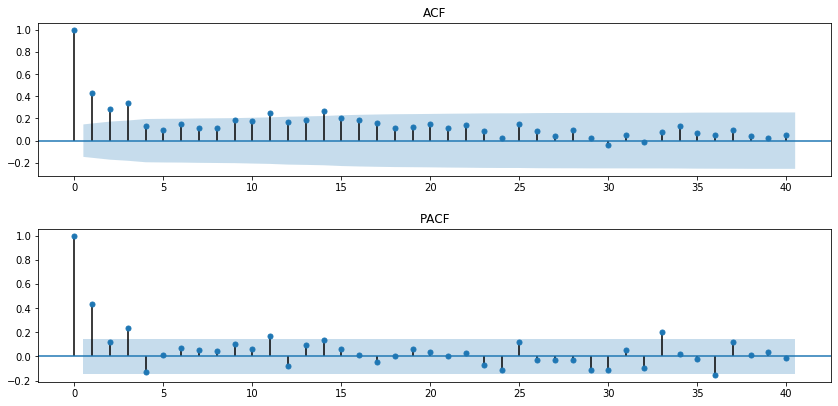

In [47]:
# Group by date to sum sales
ts = new_train.groupby(new_train.index)['sales'].sum()

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6))

# Plot ACF
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title('ACF')

# Plot PACF
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title('PACF')

plt.tight_layout(pad=2.0)

plt.show()

### Time series Interpolation

In [48]:
oil_price = new_train['price']

In [49]:
oil_price_interpolated = oil_price.interpolate(method='index')

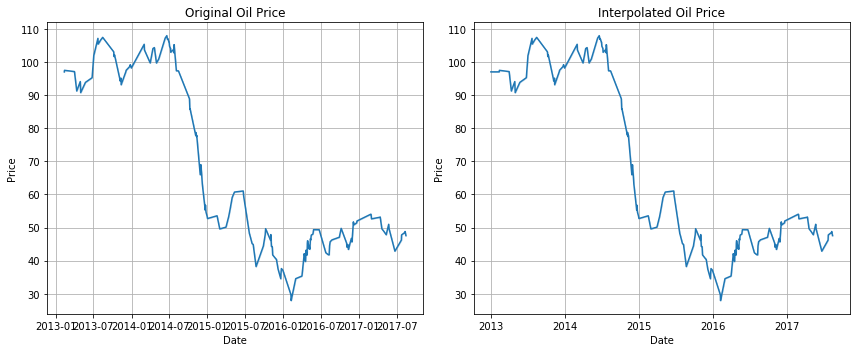

In [50]:
# Confirm changes by plotting the price with the missing values and price interpolated

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original oil price data
sns.lineplot(data=oil_price, ax=axes[0])
axes[0].set_title('Original Oil Price')

# Plot the interpolated oil price data
sns.lineplot(data=oil_price_interpolated, ax=axes[1])
axes[1].set_title('Interpolated Oil Price')

# Add labels and adjust layout
for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)

plt.tight_layout()

# Show plot
plt.show()

### Data Merging

In [51]:
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')

In [52]:
df_merged = df_merged.merge(df_oil, on='date', how='left')

In [53]:
df_merged = df_merged.merge(df_holidays, on='date', how='left')

In [54]:
# Fill in missing values introduced by merging
df_merged[['type_y', 'locale', 'locale_name']] = df_merged[['type_y', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

In [55]:
df_merged['onpromotion'] = pd.to_numeric(df_merged['onpromotion'], errors='coerce')

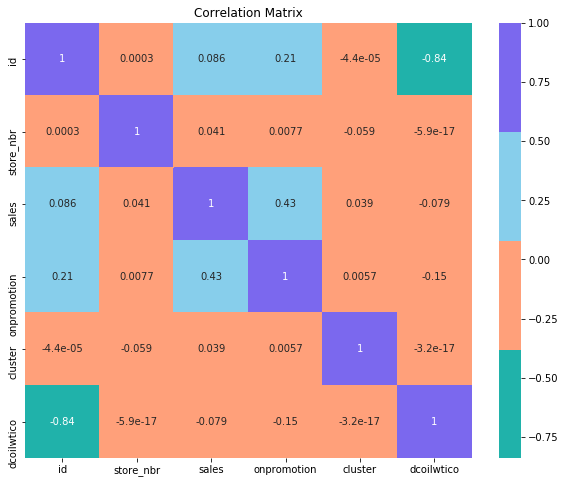

In [56]:
# Calculate the correlation matrix

# Get numeric columns
numeric_df = df_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the matrix
corr_matrix = numeric_df.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap=custom_palette)
plt.title('Correlation Matrix')
plt.show()

In [57]:
# Setting id as index
df_merged.set_index('id', inplace=True)

In [58]:
df_merged.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
id,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [59]:
# Columns we don't need so we can drop
cols_drop = ['city', 'state', 'type_x', 'dcoilwtico', 'type_y', 'locale', 'locale_name', 'transferred']

# Drop the columns
df_merged = df_merged.drop(columns=cols_drop)

In [60]:
# Put sales last
cols = [col for col in df_merged.columns if col != 'sales'] + ['sales']
df_merged = df_merged[cols]

In [61]:
# Aggregating data
df_family_aggregated = df_merged.groupby(['date', 'family']).agg({'sales': 'sum', 'onpromotion': 'sum' }).reset_index()

In [62]:
df_family_aggregated.head(10)

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.000,0
1,2013-01-01,BABY CARE,0.000,0
2,2013-01-01,BEAUTY,2.000,0
3,2013-01-01,BEVERAGES,810.000,0
4,2013-01-01,BOOKS,0.000,0
5,2013-01-01,BREAD/BAKERY,180.589,0
6,2013-01-01,CELEBRATION,0.000,0
7,2013-01-01,CLEANING,186.000,0
8,2013-01-01,DAIRY,143.000,0
9,2013-01-01,DELI,71.090,0


In [63]:
df_family_aggregated.isnull().sum()

date           0
family         0
sales          0
onpromotion    0
dtype: int64

### Feature Engineering

In [64]:
df_family_aggregated['date'] = pd.to_datetime(df_family_aggregated['date'])

In [65]:
# Create day of week feature
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# Lag sales by 1 to get previous day of sales value
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# Add rolling mean for 7-day window
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=7).mean()

In [66]:
# Drop the missing values
df_family_aggregated.dropna(inplace=True)

In [67]:
# Find shape
df_family_aggregated.shape

(55566, 7)

# Feature Encoding

In [68]:
# One-hot encoding for family column
df_family_dummies = pd.get_dummies(df_family_aggregated['family'], drop_first=True, prefix='family')

In [69]:
df_family_dummies.head(3)

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# One-hot encoding for family column
df_family_aggregated = pd.concat([df_family_aggregated, df_family_dummies], axis=1)

# No need for family column anymore
df_family_aggregated.drop('family', axis=1, inplace=True)

### Feature Scaling

In [71]:
# These columns need to be scaled
columns_to_scale = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean', 'sales'] + list(df_family_dummies.columns)

# Introduce MinMaxScaler
scaler = MinMaxScaler()

# Apply
df_family_aggregated[columns_to_scale] = scaler.fit_transform(df_family_aggregated[columns_to_scale])

In [72]:
# Sort by date
df_family_aggregated = df_family_aggregated.sort_values('date')

In [73]:
df_family_aggregated.head(4)

,date,sales,onpromotion,day_of_week,lag_1,rolling_mean,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
6,2013-01-01,0.0,0.0,0.166667,0.00019,0.000642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,2013-01-01,0.0,0.0,0.166667,0.00000,0.000051,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31,2013-01-01,0.0,0.0,0.166667,0.00000,0.000067,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30,2013-01-01,0.0,0.0,0.166667,0.00004,0.000139,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Train Test Split

In [74]:
train_size = int(0.8 * len(df_family_aggregated))
train_data = df_family_aggregated[:train_size]
test_data = df_family_aggregated[train_size:]

In [75]:
train_data.shape, test_data.shape

((44452, 38), (11114, 38))

In [76]:
# Set up training set
X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']

In [77]:
# Set up test set
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']

### Modeling

In [78]:
# Define a function to plot the predictions aganist the actuals
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Set the custom color palette
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(x=date, y=y_test, label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(x=date, y=y_pred, label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

In [79]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [80]:
# Exogenous variables to help predict sales
ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']

### ARIMA Model

In [81]:
# Define instances
model_arima = sm.tsa.ARIMA(y_train, exog=X_train[ex_variables], order=(1,0,0))

# Fit the model
results_arima = model_arima.fit()

# Make predictions
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

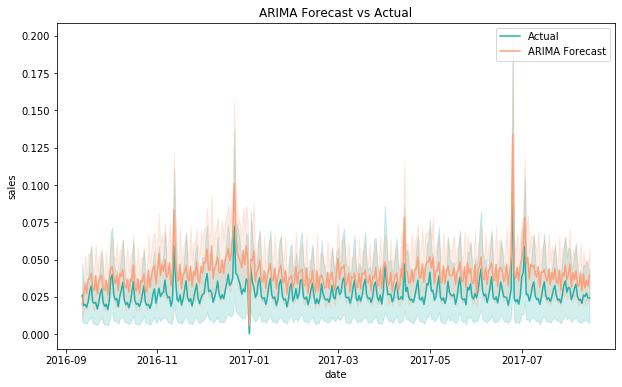

In [82]:
# Plot the predictions vs. actual
plot_predictions(test_data['date'], y_test, forecast_arima, 'ARIMA Forecast', 'ARIMA Forecast vs Actual')

In [83]:
# Calculate metrics
arima_metrics = evaluate_forecast(y_test, forecast_arima)

arima_metrics

{'MSE': 0.0017408514679347524,
 'RMSE': 0.04172351217161317,
 'RMSLE': 0.07937320405477345}

# SARIMA Model

In [84]:
# Define the instance
model_sarima = sm.tsa.SARIMAX(y_train, exog=X_train[ex_variables], order=(1,1,0), seasonal_order=(1,0,0,12))

# Fit the model
results_sarima = model_sarima.fit(disp=False)

# Make predictions
forecast_sarima = results_sarima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

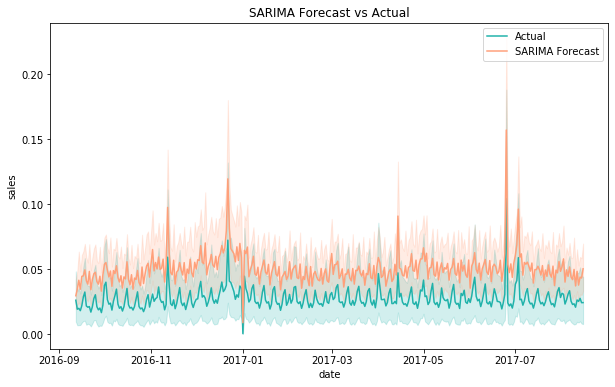

In [85]:
# Plot the predictions vs. actual
plot_predictions(test_data['date'], y_test, forecast_sarima, 'SARIMA Forecast', 'SARIMA Forecast vs Actual')

In [86]:
# Calculate metrics
sarima_metrics = evaluate_forecast(y_test, forecast_sarima)

sarima_metrics

{'MSE': 0.0022305510277748504,
 'RMSE': 0.047228709783084806,
 'RMSLE': 0.08437945413951148}

## Exponential Smoothing Model

In [ ]:
# Define Instance of the Exponential Smoothing model
model_ets = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)

# Fit the Model
results_ets = model_ets.fit()

# Make Initial Forecast
initial_forecast = results_ets.forecast(steps=len(y_test))

In [ ]:
# Use initial forecast obtained and exogenous Variables defined to predict y_test.
X_adjust_train = pd.concat([y_train.shift(-1).dropna().rename("forecast"), X_train[ex_variables].iloc[1:, :]], axis=1)
X_adjust_test = pd.concat([pd.Series(initial_forecast, index=y_test.index).rename("forecast"), X_test[ex_variables]], axis=1)

# Drop rows with missing values from both the adjusted train and test
X_adjust_train = X_adjust_train.dropna()
y_adjust_train = y_train.loc[X_adjust_train.index]

X_adjust_test = X_adjust_test.dropna()
y_adjust_test = y_test.loc[X_adjust_test.index]

# Convert feature names to strings
X_adjust_train.columns = X_adjust_train.columns.astype(str)
X_adjust_test.columns = X_adjust_test.columns.astype(str)

In [ ]:
# Define linear regression model
lr = LinearRegression()

# Fit the lr model
lr.fit(X_adjust_train, y_adjust_train)

# Predict based on X_adjust_train
forecast_ets = lr.predict(X_adjust_test)

In [ ]:
# Use our function to plot predictions vs. actual
plot_predictions(y_adjust_test.index, y_adjust_test, forecast_ets, 'Adjust ETS Forecast', 'Adjust ETS Forecast vs. Actual')

In [ ]:
# Calculate metrics 
ets_metrics = evaluate_forecast(y_adjust_test, forecast_ets)

ets_metrics

## XGBOOST Regressor Model

In [ ]:
# Define xgboost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Fit model
model_xgb.fit(X_train, y_train)

# Predict
forecast_xgb = model_xgb.predict(X_test)

In [ ]:
# Plot predictions
plot_predictions(test_data['date'], y_test, forecast_xgb, 'XGBoodt Forecast', 'XGBoost vs. Actual')

In [ ]:
# Metrics 
xgboost_metrics = evaluate_forecast(y_test, forecast_xgb)

xgboost_metrics

## Comparing Models

In [ ]:
# Make a dictionary to combine results
data = {
    'Model': ['ARIMA', 'SARIMA', 'ETS', 'XGBOOST'],
    'MSE': [arima_metrics['MSE'], sarima_metrics['MSE'], ets_metrics['MSE'], xgboost_metrics['MSE']],
    'RMSE': [arima_metrics['RMSE'], sarima_metrics['RMSE'], ets_metrics['RMSE'], xgboost_metrics['RMSE']],
    'RMSLE': [arima_metrics['RMSLE'], sarima_metrics['RMSLE'], ets_metrics['RMSLE'], xgboost_metrics['RMSLE']]
}

# Set up performance df
performance_df = pd.DataFrame(data)

performance_df

In [ ]:
# Visual display of performance
fig = px.bar(performance_df, x='Model', y='RMSLE', title='RMSLE by Model', height=600)
fig.update_xaxes(title='Model')
fig.update_yaxes(title='RMSLE')
fig.update_xaxes(categoryorder='total ascending')

# Data labels
fig.update_traces(texttemplate='%{y}', textposition='outside')

fig.show()

XGBoost is the best model, let's move forward with hyperparameter tuning.

## Hyperparameter Tuning

Going to be implementing a randomized search to fine-tune our XGBoost model. 

In [ ]:
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6]
}

# Instance of model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions = xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

In [ ]:
# Fit model
random_search.fit(X_train, y_train)

# Get best parameters
best_xgb_params = random_search.best_params_

# Print
print("Best XGBoost Parameters:", best_xgb_params)

# Get best estimator
best_xgb_model = random_search.best_estimator_

# Print out
best_xgb_model

In [ ]:
# Make a prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
xgb_best = evaluate_forecast(y_test, forecast_xgb_best)

xgb_best